In [ ]:
!uv pip install transformers torch datasets numpy scikit-learn matplotlib nlpaug flask

训练集大小: 12348
测试集大小: 4896
标签分布(训练集): Counter({1: 7400, 0: 4948})
标签分布(测试集): Counter({1: 2975, 0: 1921})


Map:   0%|          | 0/12348 [00:00<?, ? examples/s]

Map:   0%|          | 0/4896 [00:00<?, ? examples/s]

C:\Users\lyq\AppData\Local\Temp\ipykernel_3256\3728237009.py:196: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


训练集样本数: 12348
验证集样本数: 4896


Epoch,Training Loss,Validation Loss,Accuracy,Mse
1,0.848300,0.260140,0.875408,0.062415
2,0.325600,0.170378,0.914011,0.036187
3,0.204700,0.150215,0.931781,0.017397
4,0.126000,0.168464,0.938521,0.013803
5,0.071500,0.173199,0.947304,0.013976
6,0.053100,0.241356,0.943423,0.020815
7,0.029200,0.230391,0.954044,0.012889
8,0.020900,0.268610,0.947508,0.018949
9,0.017800,0.225650,0.954861,0.012018
10,0.014100,0.216979,0.955882,0.012582


预测分布： Counter({np.int64(1): 3289, np.int64(0): 1607})
预测分布： Counter({np.int64(1): 2904, np.int64(0): 1992})
预测分布： Counter({np.int64(1): 2949, np.int64(0): 1947})
预测分布： Counter({np.int64(1): 3110, np.int64(0): 1786})
预测分布： Counter({np.int64(1): 3049, np.int64(0): 1847})
预测分布： Counter({np.int64(1): 2890, np.int64(0): 2006})
预测分布： Counter({np.int64(1): 2922, np.int64(0): 1974})
预测分布： Counter({np.int64(1): 3060, np.int64(0): 1836})
预测分布： Counter({np.int64(1): 2906, np.int64(0): 1990})
预测分布： Counter({np.int64(1): 2981, np.int64(0): 1915})
预测分布： Counter({np.int64(1): 2941, np.int64(0): 1955})
预测分布： Counter({np.int64(1): 2992, np.int64(0): 1904})
预测分布： Counter({np.int64(1): 2978, np.int64(0): 1918})
预测分布： Counter({np.int64(1): 2960, np.int64(0): 1936})
预测分布： Counter({np.int64(1): 2960, np.int64(0): 1936})
预测分布： Counter({np.int64(1): 2984, np.int64(0): 1912})
训练完成! 最佳验证集准确率: 0.9593545751633987


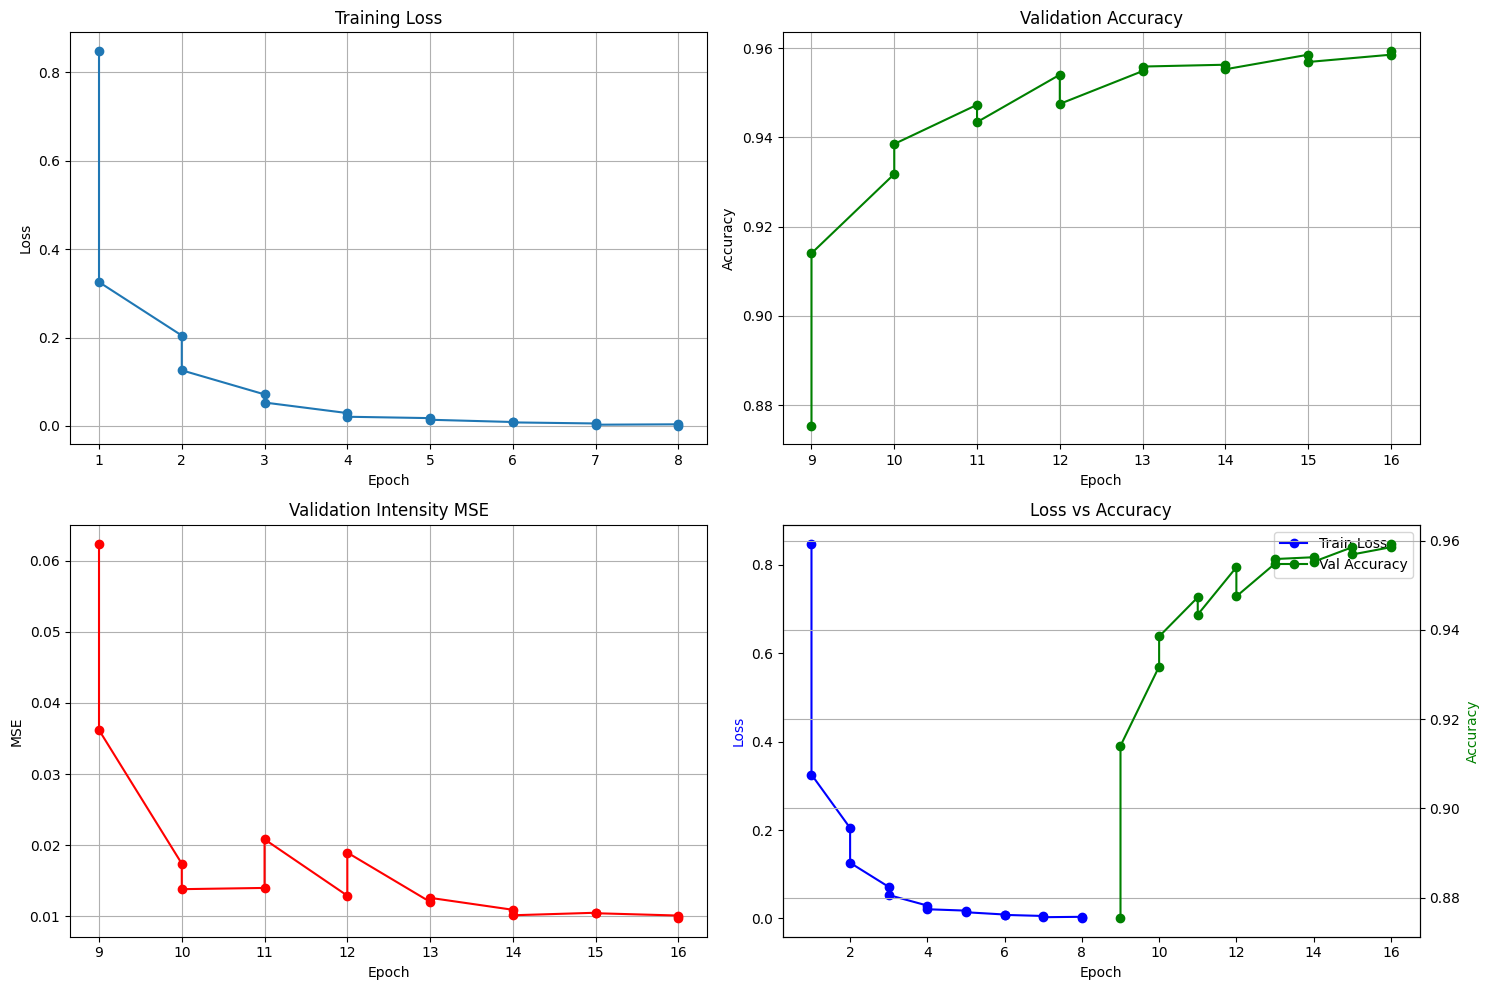

In [ ]:
from transformers import BertTokenizer, BertModel, TrainingArguments, Trainer, DataCollatorWithPadding
from torch import nn
import torch
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from transformers.modeling_outputs import ModelOutput
from typing import Optional, Tuple
from collections import Counter
from transformers import EarlyStoppingCallback, get_scheduler

import random
import re
import nlpaug.augmenter.word as naw

emotion_synonyms = {
    "开心": ["高兴", "愉快", "快乐", "兴奋"],
    "难过": ["伤心", "悲伤", "沮丧", "失落"],
    "生气": ["愤怒", "恼火", "气愤", "激动"],
    "害怕": ["恐惧", "担心", "害怕", "惊恐"],
    "喜欢": ["喜爱", "爱", "钟意", "偏爱"],
    "讨厌": ["厌恶", "嫌弃", "反感", "不喜欢"]
}


# 使用不简化的模型，并降低模型复杂度
class SimplifiedBertForEmotionMultiTask(nn.Module):
    def __init__(self, model_name, num_labels=5, dropout_rate=0.5):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)  # 保留较强的dropout
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

        # 初始化权重
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.xavier_normal_(self.regressor.weight)

    def forward(self, input_ids, attention_mask=None, labels=None, labels_intensity=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # 使用CLS向量
        cls_output = self.dropout(cls_output)  # 添加dropout

        logits = self.classifier(cls_output)
        intensity = self.regressor(cls_output).squeeze(-1)

        loss = None
        if labels is not None and labels_intensity is not None:
            loss_fct_cls = nn.CrossEntropyLoss()
            loss_fct_reg = nn.MSELoss()
            # 平衡分类和回归任务权重
            loss = 0.8 * loss_fct_cls(logits, labels) + 0.2 * loss_fct_reg(intensity, labels_intensity)

        return {"loss": loss, "logits": logits, "intensity": intensity}



# 改进的数据增强函数：使用多种增强技术
def augment_emotion_text(text, prob=0.3):
    """
    对文本进行情绪同义词替换增强。
    :param text: 原始文本
    :param prob: 每个词被替换的概率
    :return: 增强后的文本
    """
    # 策略1: 同义词替换
    for word, synonyms in emotion_synonyms.items():
        if word in text and random.random() < prob:
            new_word = random.choice([s for s in synonyms if s != word])
            text = re.sub(word, new_word, text)
    
    # 策略2: 随机删除一些非关键词（保持情绪词）
    if random.random() < prob:
        words = text.split()
        emotion_words = [word for word, _ in emotion_synonyms.items()]
        all_emotion_words = emotion_words + [syn for synonyms in emotion_synonyms.values() for syn in synonyms]
        
        # 确保不删除情绪词
        filtered_words = []
        for word in words:
            if word in all_emotion_words or random.random() > 0.2:  # 20%概率删除非情绪词
                filtered_words.append(word)
        text = ' '.join(filtered_words) if filtered_words else text
    
    return text

# ✅ Step 1: 加载中文 BERT 模型和 tokenizer
MODEL_PATH = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
# 使用简化后的模型
model = SimplifiedBertForEmotionMultiTask(MODEL_PATH)

# ✅ Step 2: 加载和切分 sepidmnorozy/Chinese_sentiment
dataset = load_dataset("sepidmnorozy/Chinese_sentiment")
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# 打印数据集分布信息
print("训练集大小:", len(train_dataset))
print("测试集大小:", len(eval_dataset))
print("标签分布(训练集):", Counter(train_dataset["label"]))
print("标签分布(测试集):", Counter(eval_dataset["label"]))

# ✅ Step 3: 数据预处理
def preprocess(example):
    original_text = example["text"]
    # 概率增强
    aug_text = augment_emotion_text(original_text)
    # 只保留情绪词
    tokens = tokenizer(aug_text, padding="max_length", truncation=True, max_length=256)
    tokens["labels"] = int(example["label"])
    tokens["labels_intensity"] = float(example["label"]) / 2.0  # 将标签转换为0-1范围
    return tokens

train_dataset = train_dataset.map(preprocess)
eval_dataset = eval_dataset.map(preprocess)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "labels_intensity"])
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "labels_intensity"])

# ✅ Step 4: 多任务模型定义（使用更强的正则化）
class BertForEmotionMultiTask(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.5):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)  # 更强的dropout
        # 正则化: 加入LayerNorm
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)
        
        # 初始化权重
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.xavier_normal_(self.regressor.weight)

    def forward(self, input_ids, attention_mask=None, labels=None, labels_intensity=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # 用CLS向量
        cls_output = self.layer_norm(cls_output)  # 添加LayerNorm
        cls_output = self.dropout(cls_output)  # 更强的dropout

        logits = self.classifier(cls_output)
        intensity = self.regressor(cls_output).squeeze(-1)

        loss = None
        if labels is not None and labels_intensity is not None:
            loss_fct_cls = nn.CrossEntropyLoss()
            loss_fct_reg = nn.MSELoss()
            # 平衡分类和回归任务权重
            loss = 0.8 * loss_fct_cls(logits, labels) + 0.2 * loss_fct_reg(intensity, labels_intensity)
            
            # 添加L2正则化 (权重衰减在优化器中处理)
        return {"loss": loss, "logits": logits, "intensity": intensity}

model = BertForEmotionMultiTask(MODEL_PATH)

# ✅ Step 5: 自定义评估指标
def compute_metrics(pred):
    logits, intensity_preds = pred.predictions
    labels, intensity_labels = pred.label_ids
    
    preds = np.argmax(logits, axis=1)
    print("预测分布：", Counter(preds))  # 观察是否只预测某一类

    acc = accuracy_score(labels, np.argmax(logits, axis=1))
    mse = mean_squared_error(intensity_labels, intensity_preds)
    return {"accuracy": acc, "mse": mse}

# ✅ Step 6: 配置训练参数（加入早停和学习率调度）
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=20,  # 设置更长的轮次，让早停生效
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,  # 稍微提高学习率
    weight_decay=0.05,   # 增加权重衰减减轻过拟合
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=3,  # 保存最佳的几个模型
    fp16=True,
    warmup_ratio=0.1,    # 学习率预热
    max_grad_norm=1.0,   # 梯度剪裁
    lr_scheduler_type="cosine",  # 余弦学习率调度
)

# 增加早停回调
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # 连续3次验证集性能没提高就停止
    early_stopping_threshold=0.001  # 最小提升阈值
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],  # 添加早停回调
)

# 训练前查看数据分布
print(f"训练集样本数: {len(train_dataset)}")
print(f"验证集样本数: {len(eval_dataset)}")

# 开始训练
train_result = trainer.train()
print(f"训练完成! 最佳验证集准确率: {trainer.state.best_metric}")

# ✅ Step 7: 绘制训练过程图
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log and "epoch" in log]
eval_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
eval_mse = [log["eval_mse"] for log in logs if "eval_mse" in log]
epochs = [log["epoch"] for log in logs if "epoch" in log and ("loss" in log or "eval_accuracy" in log)]

plt.figure(figsize=(15, 10))

# 训练损失
plt.subplot(2, 2, 1)
plt.plot(epochs[:len(train_loss)], train_loss, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# 验证准确率
plt.subplot(2, 2, 2)
plt.plot(epochs[-len(eval_acc):], eval_acc, marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

# 验证MSE
plt.subplot(2, 2, 3)
plt.plot(epochs[-len(eval_mse):], eval_mse, marker='o', color='red')
plt.title("Validation Intensity MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)

# 对比训练损失和验证准确率
plt.subplot(2, 2, 4)
ax1 = plt.gca()
ax1.plot(epochs[:len(train_loss)], train_loss, marker='o', color='blue', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')

ax2 = ax1.twinx()
ax2.plot(epochs[-len(eval_acc):], eval_acc, marker='o', color='green', label='Val Accuracy')
ax2.set_ylabel('Accuracy', color='green')

plt.title("Loss vs Accuracy")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

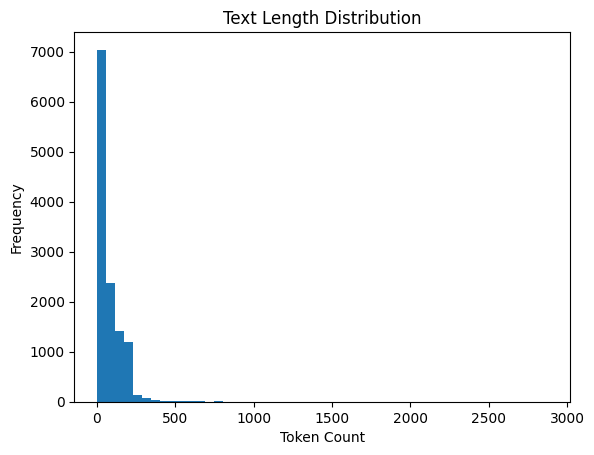


长度统计:
- 平均值: 78.6
- 中位数: 49.0
- 95%分位: 190.0
- 最大值: 2876



In [9]:
# ========== 数据分析==========
# 统计文本长度分布
text_lengths = [len(tokenizer.tokenize(text)) for text in dataset["train"]["text"]]
plt.hist(text_lengths, bins=50)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()
print(f"""
长度统计:
- 平均值: {np.mean(text_lengths):.1f}
- 中位数: {np.median(text_lengths):.1f}
- 95%分位: {np.percentile(text_lengths, 95):.1f}
- 最大值: {np.max(text_lengths)}
""")

In [6]:
torch.save(model.state_dict(), './Chinese_sentiment_model/pytorch_model.bin')
tokenizer.save_pretrained('./Chinese_sentiment_model')

('./Chinese_sentiment_model\\tokenizer_config.json',
 './Chinese_sentiment_model\\special_tokens_map.json',
 './Chinese_sentiment_model\\vocab.txt',
 './Chinese_sentiment_model\\added_tokens.json')